In [1]:
# %pip install onnxruntime-gpu onnx transformers psutil pandas py-cpuinfo py3nvml coloredlogs wget netron sympy datasets torchmetrics ipython-autotime accelerate protobuf watermark -q

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import os.path as op
import time

from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from watermark import watermark
from transformers import AutoTokenizer, DataCollatorWithPadding
torch.manual_seed(123)
%load_ext autotime

time: 101 µs (started: 2024-05-18 17:50:14 +05:30)


In [3]:
print(watermark())
print(watermark(packages="onnxruntime,onnx,transformers,accelerate,datasets,torchmetrics,pandas"))


Last updated: 2024-05-18T17:50:18.255726+05:30

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.24.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 5.15.146.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

onnxruntime : 1.17.1
onnx        : 1.16.0
transformers: 4.41.0
accelerate  : 0.30.1
datasets    : 2.19.1
torchmetrics: 1.4.0.post0
pandas      : 2.2.2

time: 1.31 s (started: 2024-05-18 17:50:18 +05:30)


In [4]:
print("Torch CUDA available?", torch.cuda.is_available())
device = "cuda:0" if torch.cuda.is_available() else "cpu"

Torch CUDA available? True
time: 30.9 ms (started: 2024-05-18 17:50:22 +05:30)


## Loading Dataset

In [5]:
data = load_dataset('imdb')
data['train'] = data['train'].shuffle(seed=42)
data['test'] = data['test'].shuffle(seed=42)

# Select only 5000 records from the train and test datasets
data['train'] = data['train'].select(range(5000))
data['test'] = data['test'].select(range(5000))
# saving into csv
data['train'].to_csv("train.csv",index=False)
data['test'].to_csv("validation.csv",index=False)

Creating CSV from Arrow format: 100%|██████████| 5/5 [00:00<00:00, 26.38ba/s]


6461083

time: 9.77 s (started: 2024-05-18 17:17:52 +05:30)


In [5]:
import pandas as pd
from torch.utils.data import DataLoader
from datasets import Dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("validation.csv")

train_dataset = Dataset.from_pandas(train)

time: 143 ms (started: 2024-05-18 17:51:25 +05:30)


## Model Loading

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)
model.to(device)

In [7]:
max_len = 512
batch_size = 32

time: 262 µs (started: 2024-05-18 17:51:46 +05:30)


## Data Loader 

In [10]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Define the IMDBDataset class
class IMDBDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, device):
        self.device = device
        texts = df.iloc[:, 0].tolist()
        labels = df.iloc[:, 1].tolist()

        input_ids = []
        attention_masks = []

        for text in texts:
            encoding = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=max_len,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'  # Get PyTorch tensors
            )
            input_ids.append(encoding['input_ids'])
            attention_masks.append(encoding['attention_mask'])
        # Convert the lists into tensors and move them to the device
        # so that we don't have to do this on for loop during inference
        self.input_ids = torch.cat(input_ids).to(device)
        self.attention_masks = torch.cat(attention_masks).to(device)
        self.labels = torch.tensor(labels, dtype=torch.long).to(device)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }


train= pd.read_csv("train.csv")
test = pd.read_csv("validation.csv")

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the dataset and data loader
train_dataset = IMDBDataset(train, tokenizer, max_len=max_len, device=device)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Create the dataset and data loader
test_dataset = IMDBDataset(test, tokenizer, max_len=max_len, device=device)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

time: 9.86 s (started: 2024-05-18 17:18:44 +05:30)


In [11]:
len(train_dataset[0]['input_ids'])

512

time: 15.3 ms (started: 2024-05-18 17:19:08 +05:30)


In [12]:
import time
from tqdm import tqdm
# Measure the latency. It is not accurate using Jupyter Notebook, it is recommended to use standalone python script.
latency = []
with torch.no_grad():
    for batch in tqdm(train_dataset):
        # both are already in the device
        inputs = {
            'input_ids':      batch['input_ids'],
            'attention_mask': batch['attention_mask']
        }
        start = time.time()
        outputs = model(**inputs)
        latency.append(time.time() - start)
print("PyTorch {} Inference time = {} ms".format(device.type, format(sum(latency) * 1000 / len(latency), '.2f')))

100%|██████████| 5000/5000 [01:38<00:00, 50.67it/s]

PyTorch cuda Inference time = 19.55 ms
time: 1min 38s (started: 2024-05-18 17:19:25 +05:30)


## Onnx Inference

In [8]:
# !pip install onnxruntime-gpu onnx -q
# !pip install onnxruntime-gpu --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/

time: 240 µs (started: 2024-05-18 17:53:31 +05:30)


In [9]:
# data type should match to input datatype
# input_ids: torch.int64
# attention_mask: torch.int64
dummy_input = {
    'input_ids': torch.randint(0, 1000, (1, max_len)),              
    'attention_mask': torch.ones((1, max_len),dtype=torch.int64)    
}
print(dummy_input['input_ids'].shape)

torch.Size([1, 512])
time: 16.1 ms (started: 2024-05-18 17:54:40 +05:30)


In [15]:
# putting model and dummy data into same device
dummy_input['input_ids'] = dummy_input['input_ids'].to(device)
dummy_input['attention_mask'] =  dummy_input['attention_mask'].to(device)

time: 2.5 ms (started: 2024-05-18 17:56:32 +05:30)


In [16]:
# checking model and dummy data in same device
print(f"Model device: {model.device}")
print(f"Dummy input device: {dummy_input['input_ids'].device}")

Model device: cuda:0
Dummy input device: cuda:0
time: 660 µs (started: 2024-05-18 17:56:34 +05:30)


In [14]:
import torch
import onnx

# Export the model
torch.onnx.export(
    model,                            # Model being run
    (dummy_input['input_ids'], dummy_input['attention_mask']),  # Model input (or a tuple for multiple inputs)
    "model.onnx",                     # Where to save the model (can be a file or file-like object)
    export_params=True,               # Store the trained parameter weights inside the model file
    opset_version=11,                 # ONNX version to export the model to
    input_names=['input_ids', 'attention_mask'],  # Input names for the model
    output_names=['output'],          # Output names for the model
    dynamic_axes={
        'input_ids': {0: 'batch_size', 1: 'sequence'},
        'attention_mask': {0: 'batch_size', 1: 'sequence'}
    }
)

print("Model has been exported to ONNX format.")

/root/miniconda3/envs/hf/lib/python3.12/site-packages/transformers/models/distilbert/modeling_distilbert.py:231: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


Model has been exported to ONNX format.
time: 2.16 s (started: 2024-05-18 16:41:54 +05:30)


### Data loader without putting into Device

In [7]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
max_len = 512
batch_size = 32

# Define the IMDBDataset class
class IMDBDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, device):
        self.device = device
        texts = df.iloc[:, 0].tolist()
        labels = df.iloc[:, 1].tolist()

        input_ids = []
        attention_masks = []

        for text in texts:
            encoding = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=max_len,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'  # Get PyTorch tensors
            )
            input_ids.append(encoding['input_ids'])
            attention_masks.append(encoding['attention_mask'])

        # Convert the lists into tensors 
        # we are not moving to cuda becuase onnx runtime requires input in cpu
        self.input_ids = torch.cat(input_ids)
        self.attention_masks = torch.cat(attention_masks)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }


train= pd.read_csv("train.csv")
# test = pd.read_csv("validation.csv")

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the dataset and data loader
train_dataset = IMDBDataset(train, tokenizer, max_len=max_len, device=device)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Create the dataset and data loader
# test_dataset = IMDBDataset(test, tokenizer, max_len=max_len, device=device)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

time: 3.86 s (started: 2024-05-18 17:25:57 +05:30)


In [17]:
import onnxruntime 
onnxruntime.get_device()

'GPU'

time: 2.26 ms (started: 2024-05-18 18:00:06 +05:30)


## Running Inference on ONNX runtime with GPU

In [15]:
import psutil
import onnxruntime
import numpy

from tqdm import tqdm
assert 'CUDAExecutionProvider' in onnxruntime.get_available_providers()
device_name = 'gpu'

sess_options = onnxruntime.SessionOptions()
output_dir ="optimized"
# this will create optimized model in output_dir
sess_options.optimized_model_filepath = os.path.join(output_dir, "optimized_model_{}.onnx".format(device_name))

# setting CPU count as intra_op_num_threads
sess_options.intra_op_num_threads=psutil.cpu_count(logical=True)
# export model path
export_model_path  ="model.onnx"
session = onnxruntime.InferenceSession(export_model_path, sess_options, providers=["CUDAExecutionProvider", "CPUExecutionProvider"])

latency = []
for batch in tqdm(train_dataset):
    # Ensure the inputs are 2D (batch_size, sequence_length)
    input_ids = batch['input_ids'].reshape(1, max_len).numpy()
    attention_mask = batch['attention_mask'].reshape(1, max_len).numpy()

    inputs = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

    start = time.time()
    outputs = session.run(None, inputs)
    latency.append(time.time() - start)

print("ONNX Runtime GPU Inference time = {} ms".format(format(sum(latency) * 1000 / len(latency), '.2f')))

2024-05-18 17:21:53.745879482 [W:onnxruntime:, inference_session.cc:1914 Initialize] Serializing optimized model with Graph Optimization level greater than ORT_ENABLE_EXTENDED and the NchwcTransformer enabled. The generated model may contain hardware specific optimizations, and should only be used in the same environment the model was optimized in.
100%|██████████| 5000/5000 [01:07<00:00, 74.56it/s]

ONNX Runtime GPU Inference time = 13.16 ms
time: 1min 9s (started: 2024-05-18 17:21:51 +05:30)


### In above we are creating optimized_model_filepath which we are going to use  without onnxruntime.SessionOptions() option
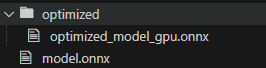


In [11]:
import psutil
import onnxruntime
import numpy

from tqdm import tqdm
assert 'CUDAExecutionProvider' in onnxruntime.get_available_providers()
device_name = 'gpu'

# sess_options = onnxruntime.SessionOptions()
# output_dir ="optimized"
# sess_options.optimized_model_filepath = os.path.join(output_dir, "optimized_model_{}.onnx".format(device_name))

# # Please change the value according to best setting in Performance Test Tool result.
# sess_options.intra_op_num_threads=psutil.cpu_count(logical=True)
# export_model_path  ="model.onnx"

# using optimized model
optimized_model = "optimized/optimized_model_gpu.onnx"
session = onnxruntime.InferenceSession(optimized_model, providers=["CUDAExecutionProvider", "CPUExecutionProvider"])

latency = []
for batch in tqdm(train_dataset):
    # Ensure the inputs are 2D (batch_size, sequence_length)
    input_ids = batch['input_ids'].reshape(1, max_len).numpy()
    attention_mask = batch['attention_mask'].reshape(1, max_len).numpy()


    inputs = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

    start = time.time()
    outputs = session.run(None, inputs)
    latency.append(time.time() - start)

print("ONNX Runtime GPU Inference time = {} ms".format(format(sum(latency) * 1000 / len(latency), '.2f')))

100%|██████████| 5000/5000 [01:06<00:00, 75.01it/s]

ONNX Runtime GPU Inference time = 13.09 ms
time: 1min 8s (started: 2024-05-18 17:28:39 +05:30)


In [23]:
pytorch_inference_time = 98 #sec           #1 min 38 sec
onnx_inference_time = 68 #sec              #1 min 8 sec
speed_diff = (pytorch_inference_time - onnx_inference_time) / pytorch_inference_time * 100
print("ONNX Runtime GPU is {:.2f}% faster than PyTorch".format(speed_diff))
print()

ONNX Runtime GPU is 30.61% faster than PyTorch

time: 709 µs (started: 2024-05-18 18:09:38 +05:30)


In [25]:
# latency analysis
pytorch_latency_time = 19.55    # ms 
onnx_latency_time = 13.09       # ms
latency_diff = (pytorch_latency_time - onnx_latency_time) / pytorch_latency_time * 100
print("ONNX Runtime GPU avg Latency is {:.2f}% faster than PyTorch".format(latency_diff))
print()

ONNX Runtime GPU avg Latency is 33.04% faster than PyTorch

time: 454 µs (started: 2024-05-18 18:12:11 +05:30)
